# machine readable zone "MRZ"

In [71]:
"""
Description
    Write an algorithm to extract machine readable zone "MRZ" in attached images . 
    Input  is image .
    Output is txt file has 2 lines ("MRZ") .
"""

'\nDescription\n    Write an algorithm to extract machine readable zone "MRZ" in attached images . \n    Input  is image .\n    Output is txt file has 2 lines ("MRZ") .\n'

# Overall architecture

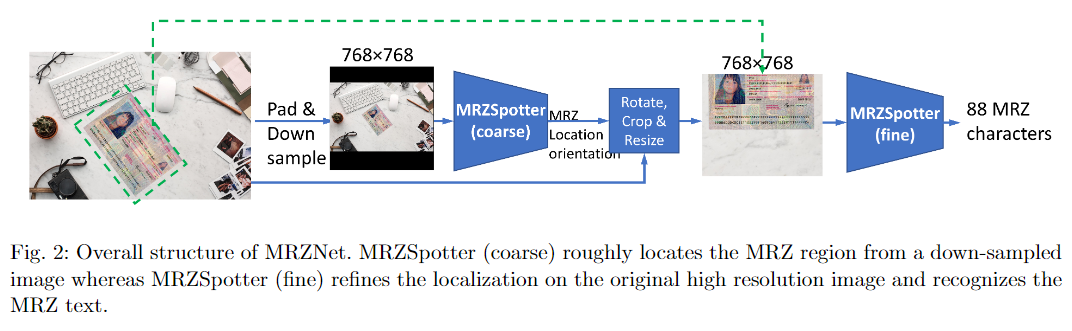

MRZ text found in passport and visa is always
2 lines, 44 characters per line,

# 1.  import Libraries

In [72]:
# import the necessary packages
import sys
import cv2
import os
import imutils
import numpy as np
import pytesseract
from imutils import paths
import matplotlib.pyplot as plt
from imutils.contours import sort_contours

%matplotlib inline

# 2. load images

In [73]:
Images_path = "D:\Ahmed\company\CyShild\Assignment\Computer Vision\images"
print(os.listdir(Images_path))

def load_images(path):
    images_list = []
    images_path =os.listdir(Images_path)
    for image in images_path:
        img_path = os.path.join(Images_path, image)
        img_cv = cv2.imread(img_path)
        image = imutils.resize(img_cv, height=600)
        images_list.append(img_cv)
    return images_list


# apply load images
images = load_images(Images_path)


['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.png']


# 3. Images Preprocessing

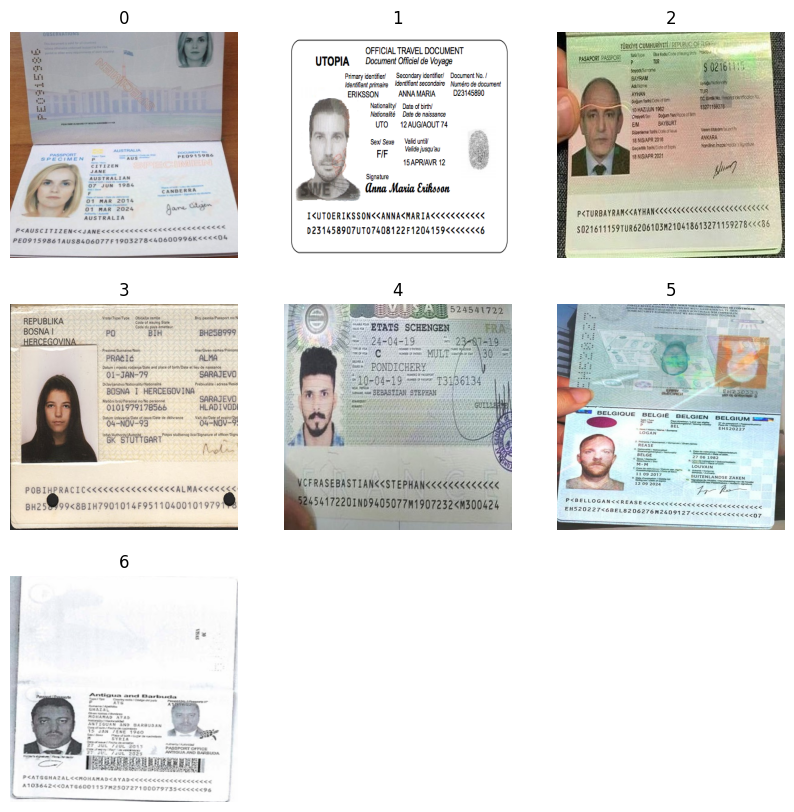

In [74]:
# Images Visualization
def plot_images_rgb(images):
    plt.figure(figsize=(10,10))
    for idx, image in enumerate(images):
        plt.subplot(3, 3, idx+1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb, aspect='auto')
        plt.title(idx)
        plt.axis("off")

def plot_images(images):
    plt.figure(figsize=(10,10))
    for idx, image in enumerate(images):
        plt.subplot(3, 3, idx+1)
        plt.imshow(image)
        plt.title(idx)
        plt.axis("off")
        
# apply Visualization       
plot_images_rgb(images)

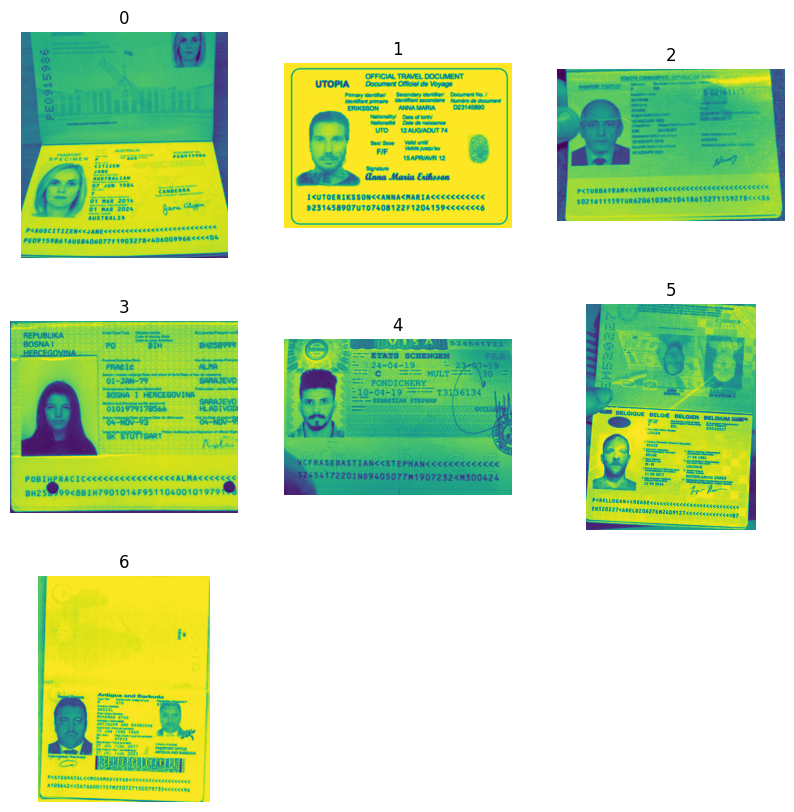

In [76]:
def preprocess_gray(images):
    gray_images = []
    gray_shapes = []
    for image in images:
        # load the image, resize it, and convert it to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # smooth the image using a 3x3 Gaussian, then apply the blackhat
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        gray_images.append(gray)
    return gray_images

# apply images preprocessing
gray_images = preprocess_gray(images)
plot_images(gray_images)

# 4. Perform OCR on the preprocessed image

In [75]:
# configuration pytesseract and initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## 4.2 MRZSpotter coarse

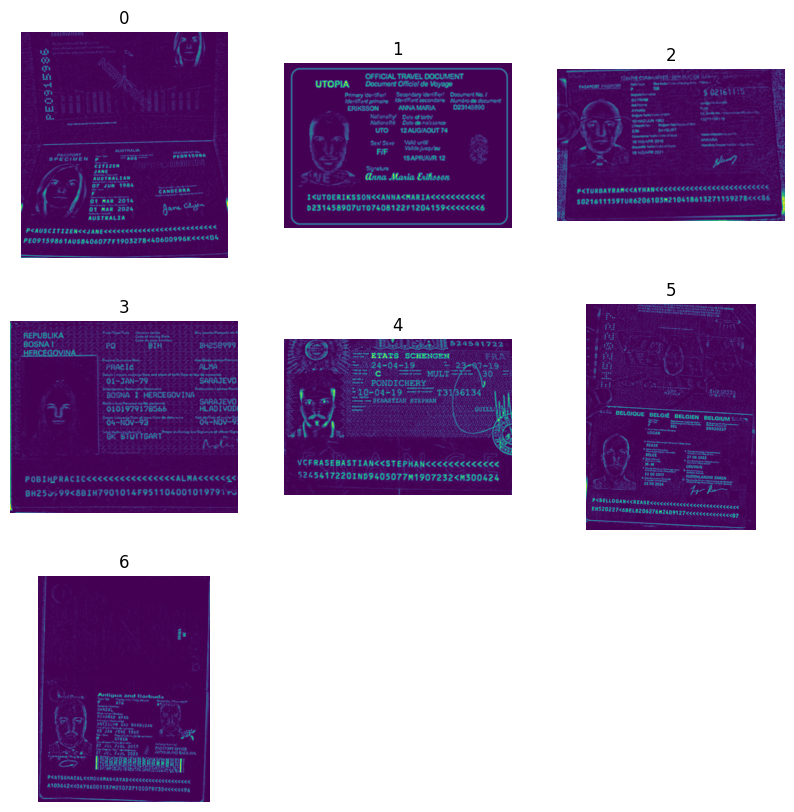

In [77]:
# smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light background
def preprocess_blackhat(images):
    blackhat_images = []
    for gray in images:
        # morphological operator to find dark regions on a light background
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
        blackhat_images.append(blackhat)
    return blackhat_images

# apply images preprocessing
blackhat_images = preprocess_blackhat(gray_images)
plot_images(blackhat_images)

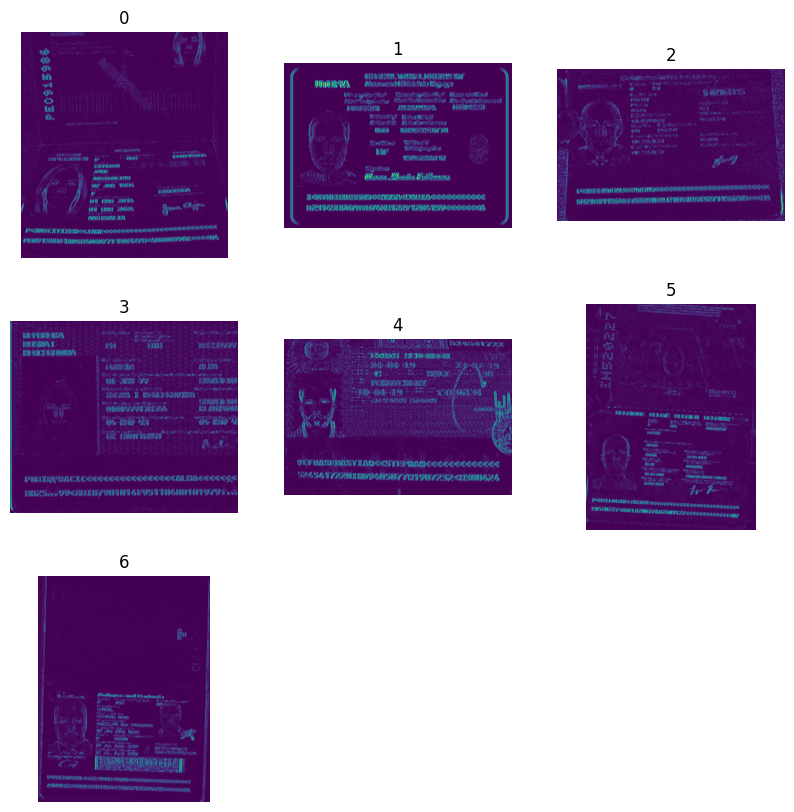

In [78]:
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]

def preprocess_scale(images):
    scale_images = []
    for blackhat in images:
        gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
        scale_images.append(gradX)
    return scale_images

# apply images preprocessing
scale_images = preprocess_scale(blackhat_images)
plot_images(scale_images)

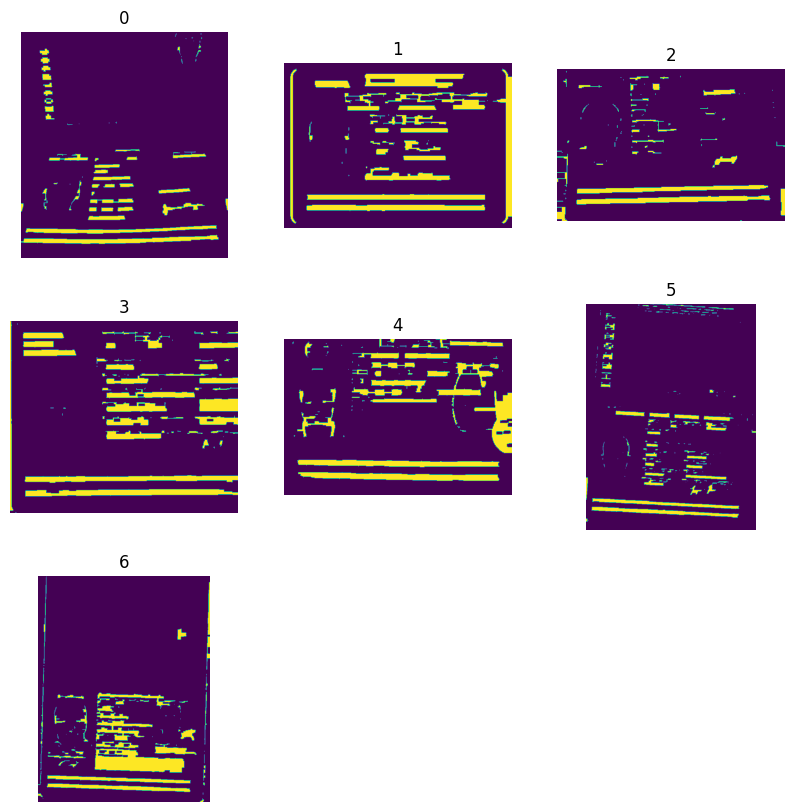

In [79]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method

def preprocess_thresh(images):
    thresh_images = []
    for gradX in images:
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
        thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        thresh_images.append(thresh)
    return thresh_images

# apply images preprocessing
thresh_images = preprocess_thresh(scale_images)
plot_images(thresh_images)

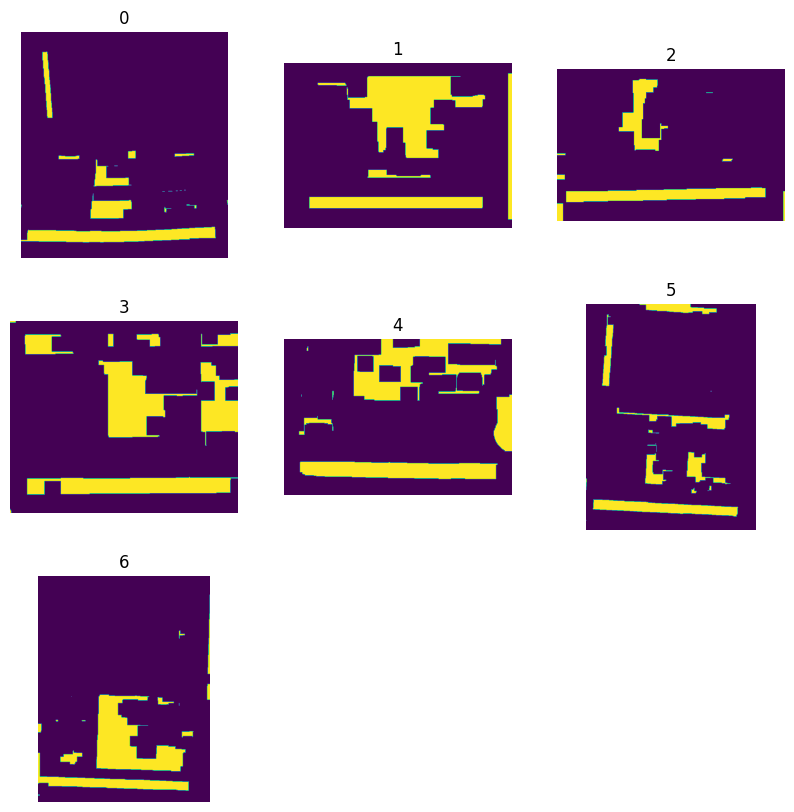

In [80]:
# perform another closing operation, this time using the square
# kernel to close gaps between lines of the MRZ, then perform a
# series of erosions to break apart connected components
def preprocess_thresh_2(images):
    thresh_images_2 = []
    for thresh in images:
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
        thresh = cv2.erode(thresh, None, iterations=4)
        thresh_images_2.append(thresh)
    return thresh_images_2

# apply images preprocessing
thresh_images_2 = preprocess_thresh_2(thresh_images)
plot_images(thresh_images_2)

In [81]:
# find contours in the thresholded image and sort them from bottom
# to top (since the MRZ will always be at the bottom of the passport)
def find_contours(thresh_images_2, images):
    contours = []
    for idx, thresh in enumerate(thresh_images_2):
        
        # during thresholding, it's possible that border pixels were
        # included in the thresholding, so let's set 5% of the left and
        # right borders to zero
        p = int(images[idx].shape[1] * 0.05)
        thresh[:, 0:p] = 0
        thresh[:, images[idx].shape[1] - p:] = 0
    
        # find contours in the thresholded image and sort them by their # size
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        contours.append(cnts)
    return contours

# apply images preprocessing
contours = find_contours(thresh_images_2, images)

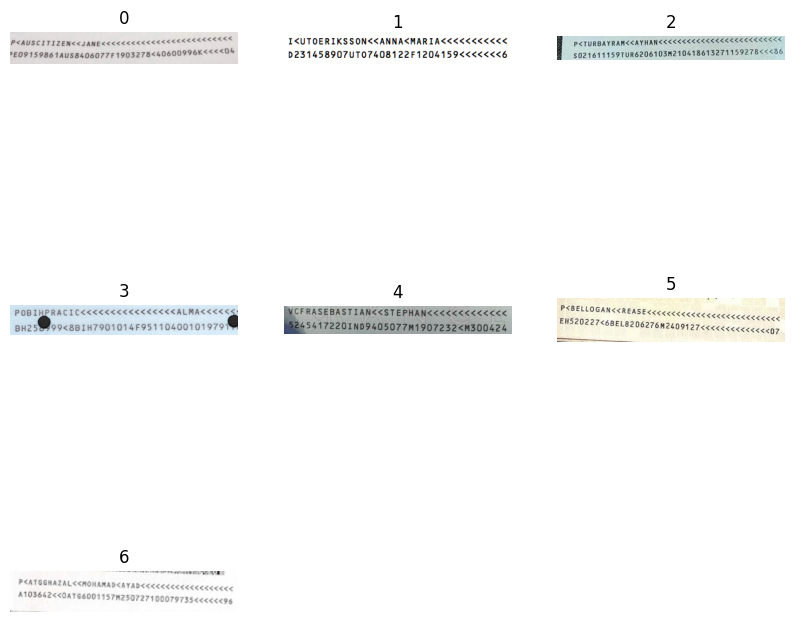

In [82]:
def padded_MRZ(contours, gray_images, images):
    padded_MRZ = []
    # loop over the contours
    for idx, cnts in enumerate(contours):
        
        for c in cnts:
            # compute the bounding box of the contour and use the contour to
            # compute the aspect ratio and coverage ratio of the bounding box
            # width to the width of the image
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)
            crWidth = w / float(gray_images[idx].shape[1])
            # check to see if the aspect ratio and coverage width are within
            # acceptable criteria
            roi = images[idx]
            if ar > 5 and crWidth > 0.75:
                # pad the bounding box since we applied erosions and now need
                # to re-grow it
                pX = int((x + w) * 0.03)
                pY = int((y + h) * 0.03)
                (x, y) = (x - pX, y - pY)
                (w, h) = (w + (pX * 2), h + (pY * 2))
                # extract the ROI from the image and draw a bounding box
                # surrounding the MRZ
                roi = images[idx][y:y + h, x:x + w].copy()
                cv2.rectangle(images[idx], (x, y), (x + w, y + h), (0, 255, 0), 2)
                break
        padded_MRZ.append(roi)
    return padded_MRZ


# apply images preprocessing
mrz_images = padded_MRZ(contours, gray_images, images)
plot_images(mrz_images)

## 4.3 MRZSpotter fine

In [83]:
# Perform OCR on the preprocessed image
config = ('-l eng --oem 1 --psm 3')

def Perform_OCR(mrz_images):
    mrz_texts = []
    for gray in mrz_images:
        mrz_text = pytesseract.image_to_string(gray, config = config)
        mrz_texts.append(mrz_text)
    return mrz_texts

#apply Perform OCR Function
mrz_texts = Perform_OCR(mrz_images)

# 5. Saving result in file

In [84]:
# Save the MRZ lines to a text file
with open('mrz.txt', 'w') as f:
    f.write('\n'.join(mrz_texts))